In [7]:
%load_ext autoreload
%autoreload 2

import torch
import json
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from model import Llama2Helper, init_tokenizer
from utils import load_pile, get_subset_from_dataset, get_hf_token, get_skip_tokens, acc, check_gpu_memory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
with open("../results/alignment_tax_v0.15.json", "r") as f:
    results = json.load(f)

In [68]:
#TODO: really messy code, should work on changing the structuring of the results
accs = {}
modes = ("only_text", "only_code")
injection_coefficients = list(results["only_code"].keys())
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")


for mode in modes:
    accs[mode] = {}
    for metric in metrics:
        accs[mode][metric] = [0]*len(injection_coefficients), [0]*len(injection_coefficients)
    
    for i, ic in enumerate(injection_coefficients):
        keys_batches = results[mode][ic].keys()
        for batch in keys_batches:
            for metric in metrics:
                accs[mode][metric][0][i] += results[mode][ic][batch][metric]
                accs[mode][metric][1][i] += 1

for mode in modes:
    for metric in metrics:
        sum_scores, counts = accs[mode][metric]
        avg_scores = [sum_score / count for sum_score, count in zip(sum_scores, counts)]
        relative_scores = [avg_score / avg_scores[0]*100 for avg_score in avg_scores]
        accs[mode][metric] = relative_scores

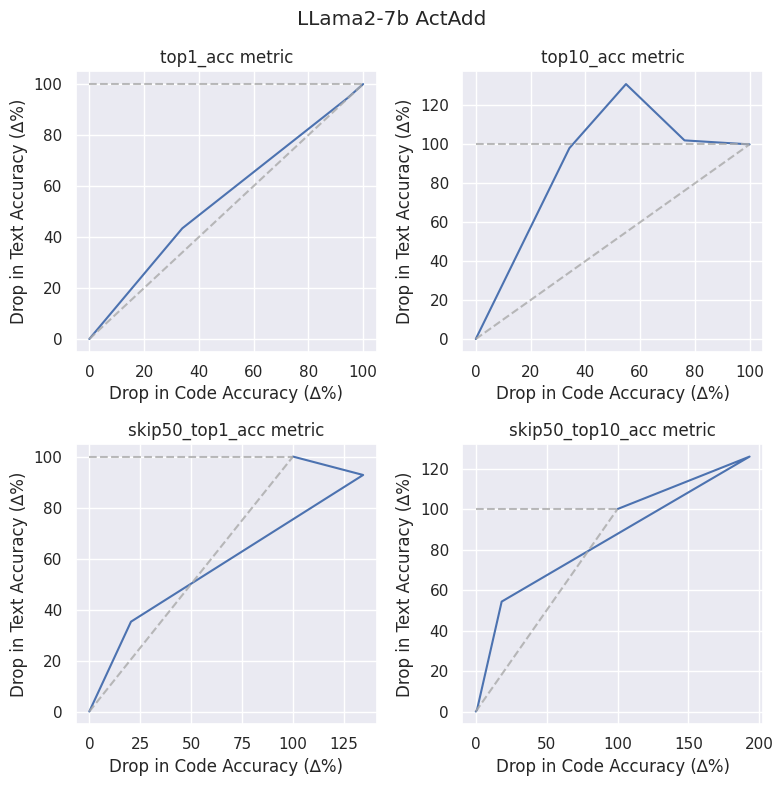

In [72]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(8,8))
scale = 100

for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.plot(accs["only_code"][metric], accs['only_text'][metric])
    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Drop in Code Accuracy (∆%)")
    ax.set_ylabel("Drop in Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.8)

plt.suptitle("LLama2-7b ActAdd")
fig.tight_layout()
plt.show()